In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.signal as signal
import imageio
import sys
from scipy.signal import butter, lfilter, get_window, medfilt
import pywt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
import statsmodels.graphics.tsaplots as tsaplots
import random
import scipy.stats
import torch
import torch.nn as nn
from scipy.signal import savgol_filter, medfilt, find_peaks

import sys

sys.path.append("../")
sys.path.append("../scripts")

from scripts.phase_detect import optimize_breakpoint
from scripts.denoising_models import (
    polyfit_model,
    polyfit_model_2,
    calibrate_signal,
    calibrate_signal_with_prior,
    calibrate_train,
    wavelet_smoothing,
    model_runner,
)
import scripts.metrics as metrics
from file_io import read_files
from preprocess import subtract_background, spatial_integration, bin_frequencies
from phase_detect import detector_runner, phase_detector, detect_best_breakpoint
from plotting_scripts import (
    plot_time_series_analysis,
    plot_relationships,
    plot_score_vs_constant,
)
from spectrum_calc import calculate_spectrum, ratio_from_timeseries
from metrics import simple_score, score
from generate_lc import idealized_light_curve, generate_ideal_wc

In [184]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
gt_df = pd.read_csv("../data/raw/train_labels.csv")
target_star_list = gt_df.planet_id

In [186]:
# Prediction sequence
selected_targets = target_star_list[:50]


def prediction_logic(target_list, gt_df=gt_df):

    # read files
    airs_selected = []
    fgs_selected = []
    gt_selected = []

    for target in target_list:
        airs, fgs, gt = read_files(target, gt_df)
        airs_selected.append(airs)
        fgs_selected.append(fgs)
        gt_selected.append(gt)

    airs_selected = np.vstack(airs_selected)
    fgs_selected = np.vstack(fgs_selected)
    gt_selected = np.vstack(gt_selected)
    print("file read")

    # PREPROCESS
    # 1. subtracting the estimated background signal;
    airs_selected = subtract_background(airs_selected)
    # 2. integrate spatially across the center of the detector. Output shape of observations * t * freq
    airs_selected = spatial_integration(airs_selected)

    # 3. additional smoothing step
    # airs_selected = wavelet_smoothing(airs_selected, 5) # wavelet smoothing seems to decrease the max-min range of signal, we will skip this for now

    # DE-TREND
    # phase detection - returns the estimated instants at which entry and exit occurs for each eclipse event
    # plt.plot(airs_selected[0].sum(axis=1))
    # plt.show()
    lc_phases, wc_phases = detector_runner(airs_selected, optimize_breakpoint)
    # print(wc_phases)
    # print(lc_phases)

    lc_phases = np.tile(
        wc_phases[:, np.newaxis, :], (1, 282, 1)
    )  # we will use wc_phases for both lc and wc for the time being, due to resolution limits

    # Frequency Binning:
    binned_airs_selected = bin_frequencies(airs_selected, 10)
    # plt.plot(binned_airs_selected[0].sum(axis=1))

    fitted_lc, fitted_wc = model_runner(
        binned_airs_selected, lc_phases, wc_phases, calibrate_signal
    )  # added median smoothing to the model runner

    # plt.plot(fitted_wc[0])
    # Cal prediction
    lc_ratio, wc_ratio = calculate_spectrum(fitted_lc, fitted_wc, lc_phases, wc_phases)

    return (
        airs_selected,
        lc_phases,
        wc_phases,
        fitted_lc,
        fitted_wc,
        gt_selected,
        lc_ratio,
        wc_ratio,
    )
    print(airs_selected.shape)


def run_in_batches(data, batch_size=50):
    # Initialize a list to collect outputs
    airs_selected = []
    lc_phases = []
    wc_phases = []
    fitted_lc = []
    fitted_wc = []
    gt_selected = []
    lc_ratio = []
    wc_ratio = []

    # Loop over data in specified batch sizes
    for start in range(0, len(data), batch_size):
        end = min(start + batch_size, len(data))  # Ensure we don't go out of bounds
        batch = data[start:end]

        # Run your prediction function on the current batch
        (
            airs_selected_1,
            lc_phases_1,
            wc_phases_1,
            fitted_lc_1,
            fitted_wc_1,
            gt_selected_1,
            lc_ratio_1,
            wc_ratio_1,
        ) = prediction_logic(batch)

        # Append the output to the list
        airs_selected.append(airs_selected_1)
        lc_phases.append(lc_phases_1)
        wc_phases.append(wc_phases_1)
        fitted_lc.append(fitted_lc_1)
        fitted_wc.append(fitted_wc_1)
        gt_selected.append(gt_selected_1)
        lc_ratio.append(lc_ratio_1)
        wc_ratio.append(wc_ratio_1)

    # Stack all outputs vertically into a single array
    airs_selected = np.vstack(airs_selected)
    lc_phases = np.vstack(lc_phases)
    wc_phases = np.vstack(wc_phases)
    fitted_lc = np.vstack(fitted_lc)
    fitted_wc = np.vstack(fitted_wc)
    gt_selected = np.vstack(gt_selected)
    lc_ratio = np.vstack(lc_ratio)
    wc_ratio = np.vstack(wc_ratio)
    return (
        airs_selected,
        lc_phases,
        wc_phases,
        fitted_lc,
        fitted_wc,
        gt_selected,
        lc_ratio,
        wc_ratio,
    )


(
    airs_selected,
    lc_phases,
    wc_phases,
    fitted_lc,
    fitted_wc,
    gt_selected,
    lc_ratio,
    wc_ratio,
) = run_in_batches(selected_targets)

file read
(50, 187, 282)


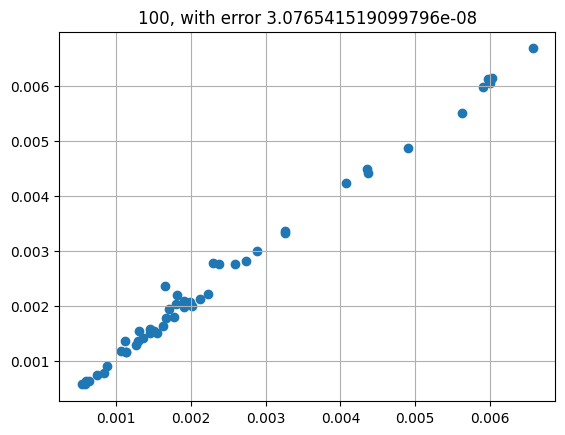

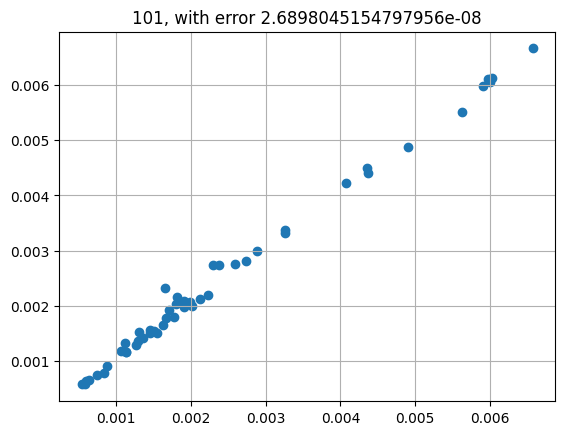

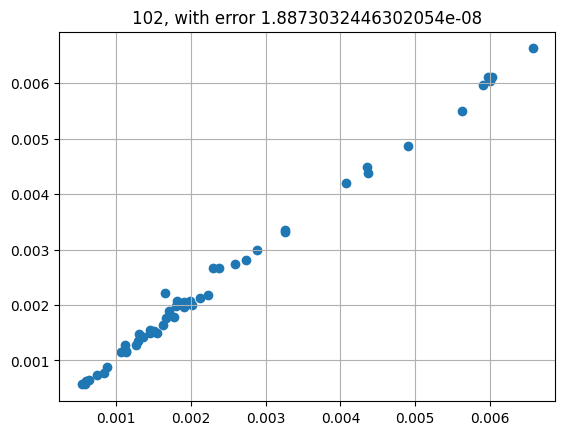

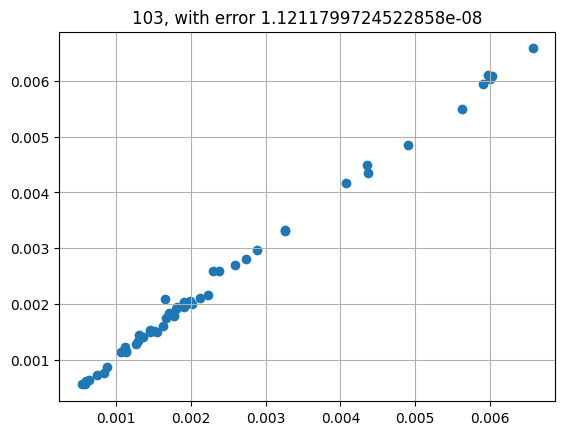

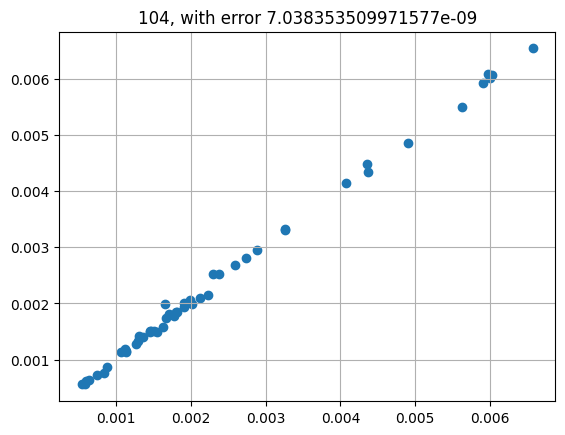

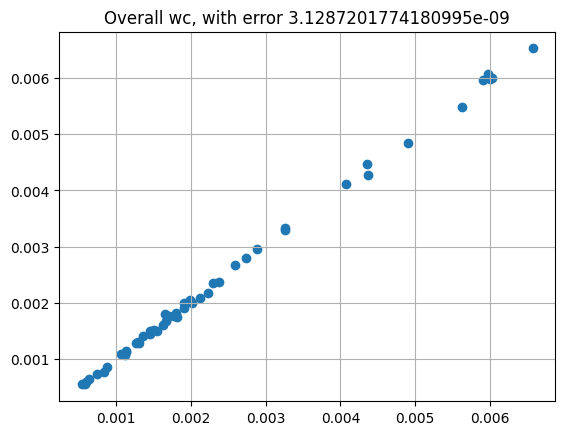

In [187]:
for i in range(100, 105):
    observation = i
    plt.scatter(wc_ratio[:, observation], gt_selected[:, observation])
    plt.grid(True)
    plt.title(
        f"{observation}, with error {((wc_ratio[:,observation] - gt_selected[:,observation])**2).mean()}"
    )
    plt.show()
    # print(((lc_ratio[:,observation] - gt_selected[:,observation])**2).mean())

plt.scatter(wc_ratio[:, 0], gt_selected[:, :-2].mean(axis=1))
plt.grid(True)
plt.title(
    f"Overall wc, with error {((wc_ratio[:,0] - gt_selected[:,:-2].mean(axis=1))**2).mean()}"
)
plt.show()

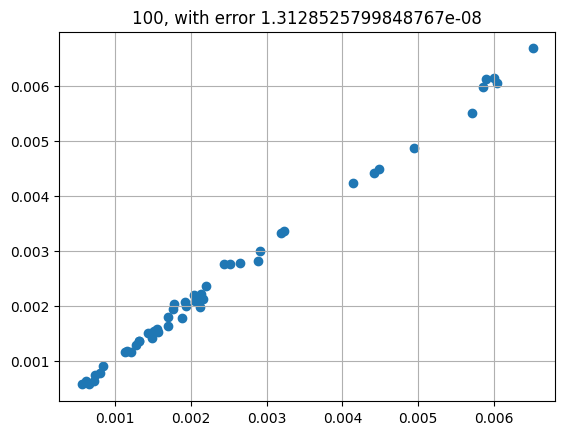

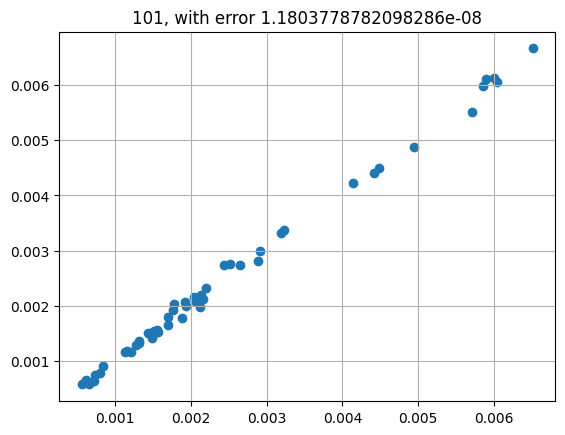

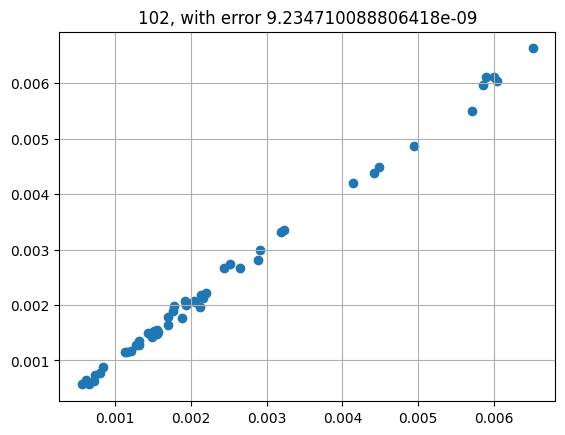

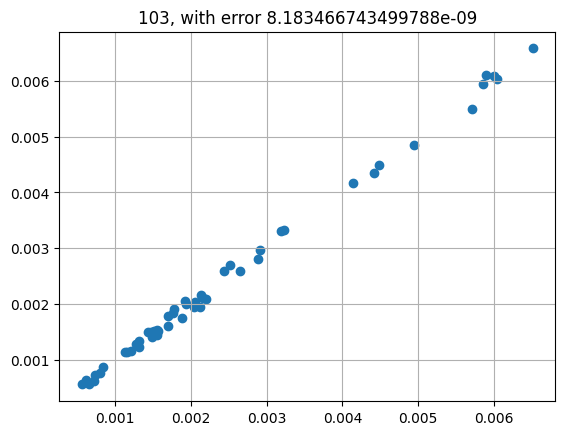

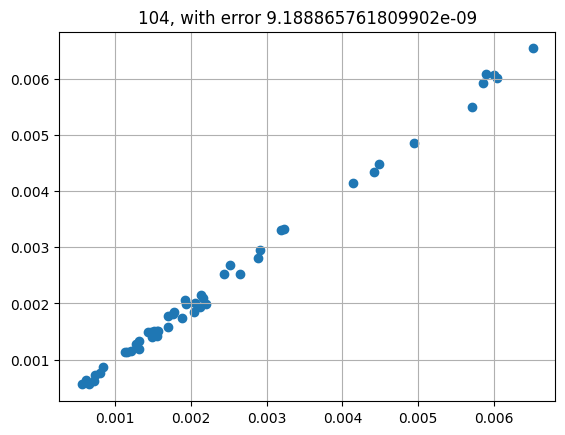

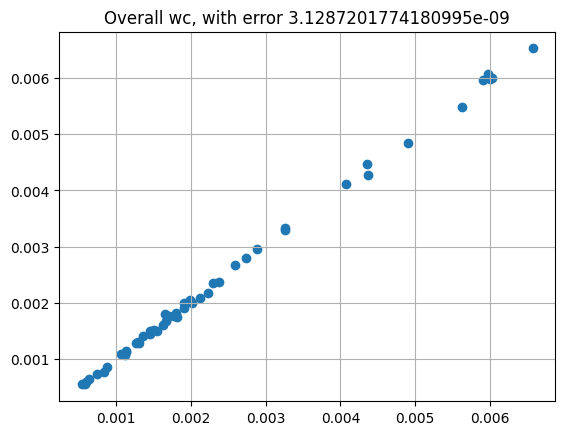

In [188]:
# From the below plots, it looks like when we err, we under estimate transit depth
for i in range(100, 105):
    observation = i
    plt.scatter(lc_ratio[:, observation], gt_selected[:, observation])
    plt.grid(True)
    plt.title(
        f"{observation}, with error {((lc_ratio[:,observation] - gt_selected[:,observation])**2).mean()}"
    )
    plt.show()
    # print(((lc_ratio[:,observation] - gt_selected[:,observation])**2).mean())

plt.scatter(wc_ratio[:, 0], gt_selected[:, :-2].mean(axis=1))
plt.grid(True)
plt.title(
    f"Overall wc, with error {((wc_ratio[:,0] - gt_selected[:,:-2].mean(axis=1))**2).mean()}"
)
plt.show()

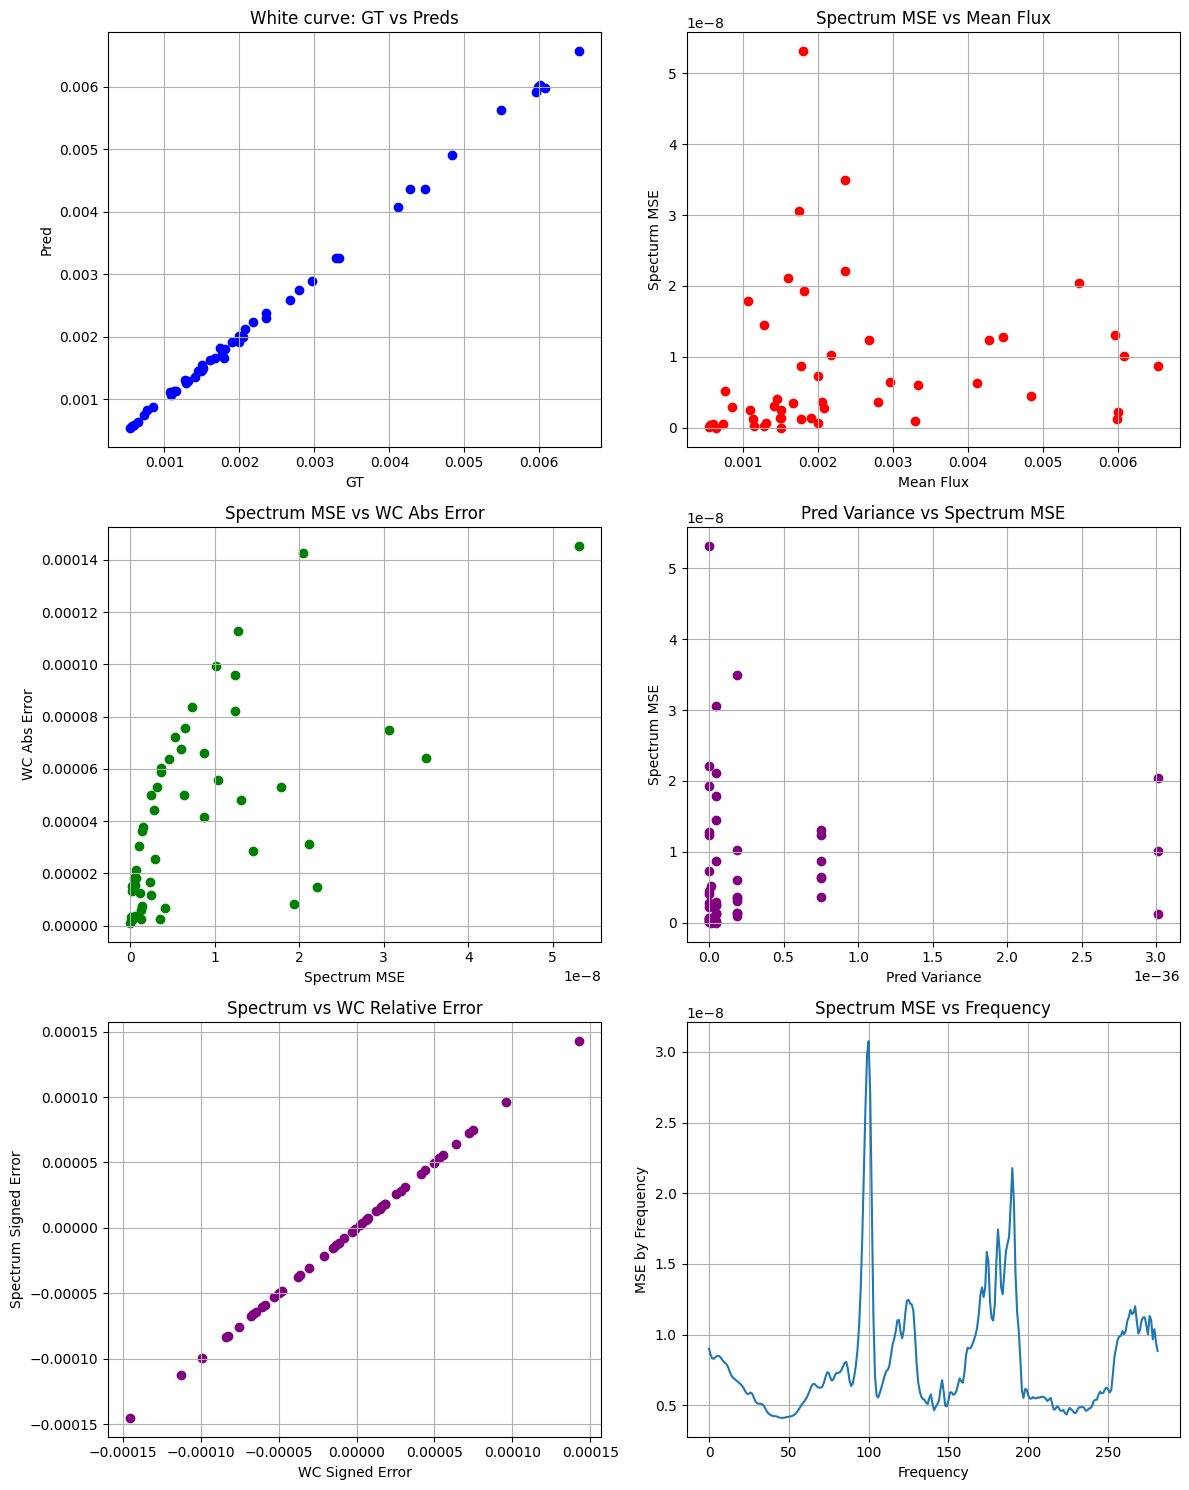

In [189]:
plot_relationships(wc_ratio, wc_ratio[:, 0], gt_selected[:, :-2])

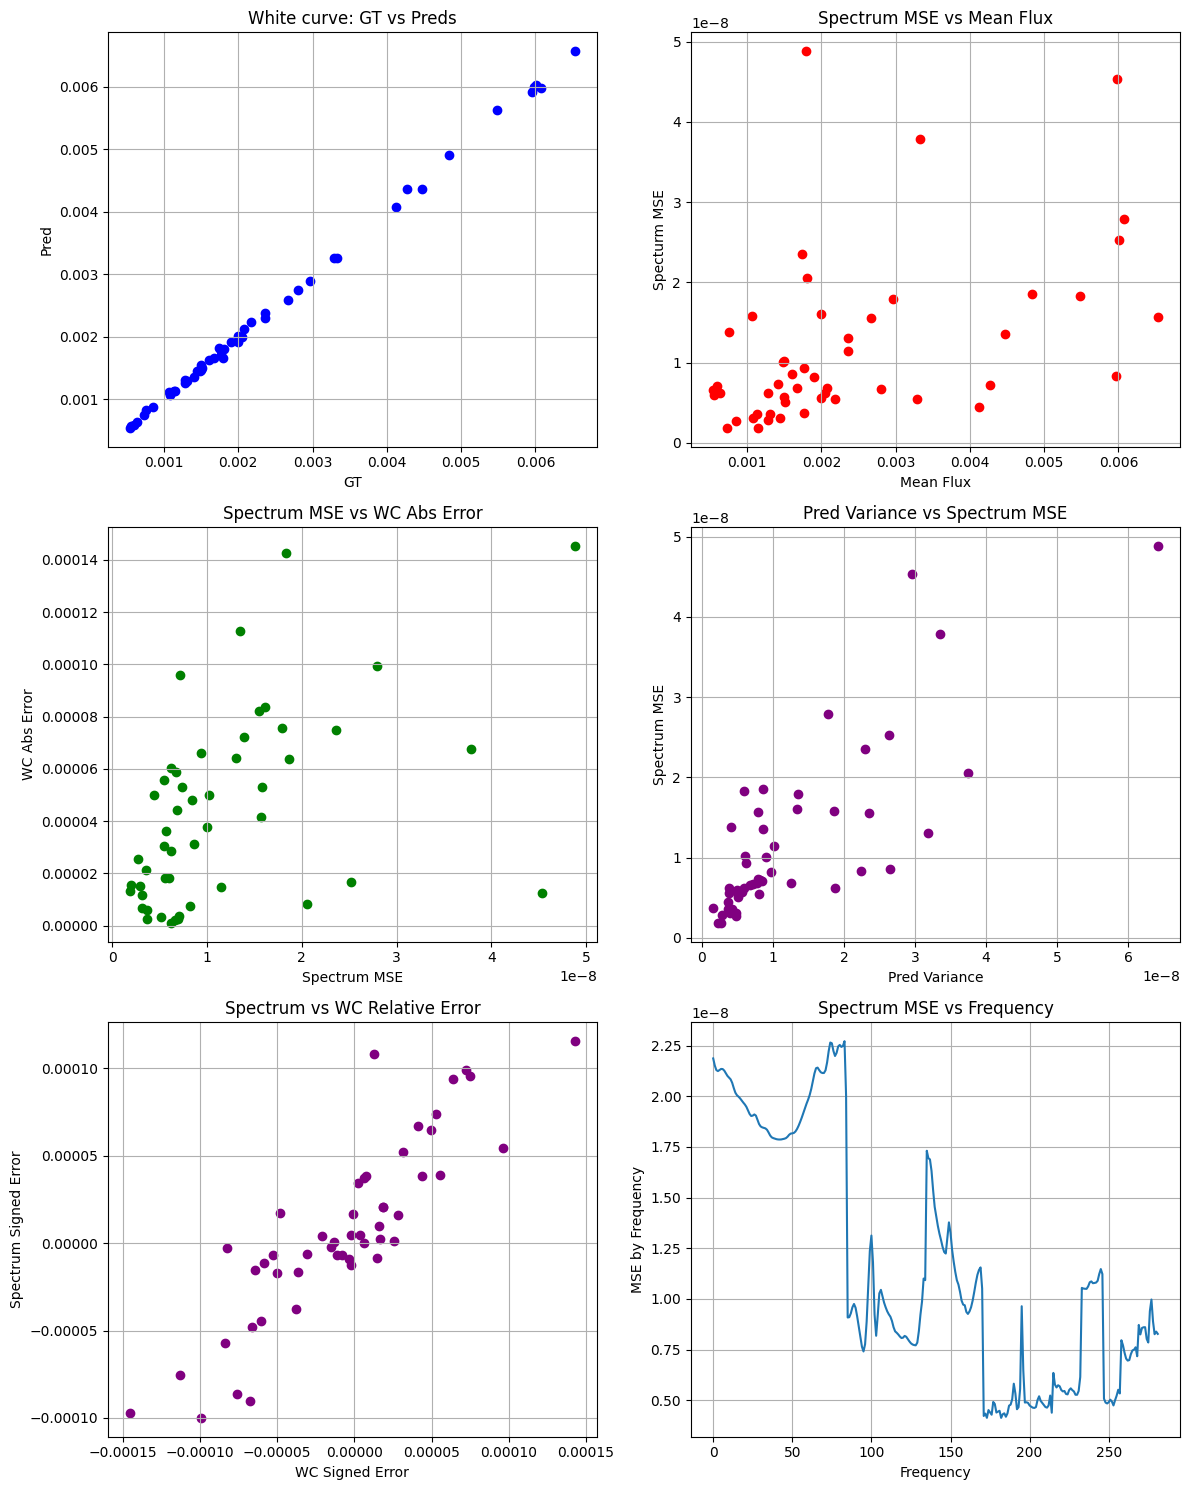

In [190]:
plot_relationships(lc_ratio, wc_ratio[:, 0], gt_selected[:, :-2])

In [208]:
# Further diagnostics
# we expect to see a straight line here, as we are plotting the empirically estimated standard devation against measured error

sigmas_single = [np.std((lc_ratio[:, ::-1] - gt_df.iloc[:, 2:].values), axis=0)]

plt.scatter(
    sigmas_single[0][::-1], ((lc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0) ** 0.5
)
plt.show()
plt.scatter(sigmas_single[0] * 1.5, sigmas[0][1:])

ValueError: operands could not be broadcast together with shapes (50,282) (673,282) 

In [ ]:
# sigmas_single
np.save("../outputs/results/sigmas_single.npy", sigmas_single)
np.save("../outputs/results/lc_ratio.npy", lc_ratio)
np.save("../outputs/results/sigmas_single.npy", wc_ratio)

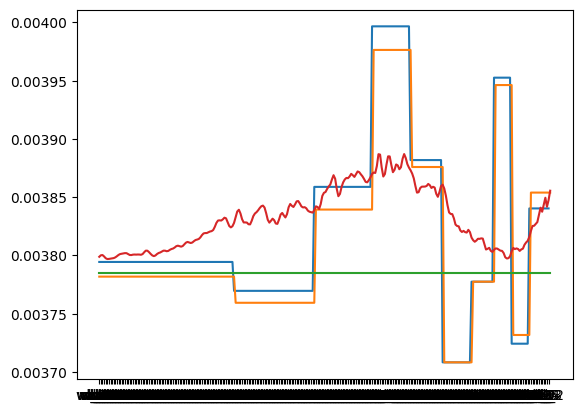

In [ ]:
target = 50
# plt.plot(sample_sub.iloc[target, 2:283][::-1], label="sub")
plt.plot(lc_ratio[target], label="lc")
plt.plot(wc_ratio[target], label="wc")
plt.plot(gt_selected[target, :-2], label="gt")

Here we try to do Neural net to detect noise ;)

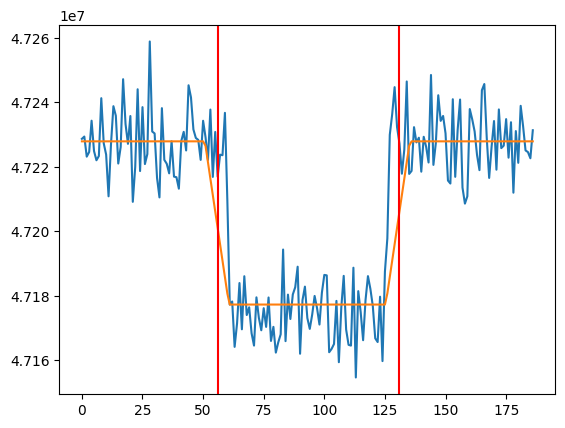

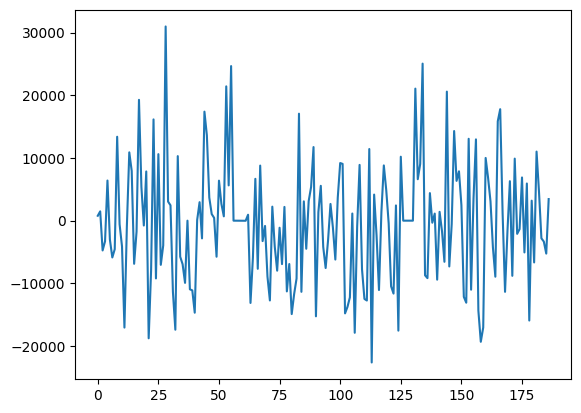

In [152]:
freq = 3
initial_lc = fitted_lc[0][:, freq]
ingress, egress = lc_phases[0][freq]
absorption = gt_selected[0][freq]
ideal_curve = (
    idealized_light_curve(initial_lc, absorption, ingress, egress, 5)
    * initial_lc[:10].mean()
)
# stitched_curve = np.hstack([ideal_curve[:ingress], initial_lc[ingress:ingress+5], ideal_curve[ingress+5:egress-5], initial_lc[egress-5:egress], ideal_curve[egress:]])

plt.plot(initial_lc)
plt.plot(ideal_curve)
# plt.plot(stitched_curve)
plt.axvline(x=ingress, color="red")
plt.axvline(x=egress, color="red")
plt.show()

plt.plot(initial_lc - stitched_curve)

In [179]:
lc_ratio.shape

(673, 282)

In [213]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc_seq = nn.Linear(16 * (input_size // 2), output_size)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))  # Fix applied here
        x = x.view(x.size(0), -1)
        x = self.fc_seq(x)
        return x


# Hyperparameters
input_size = 282  # Length of the input sequence
hidden_size = 64
output_size = 282  # Length of the output sequence
num_epochs = 10
learning_rate = 0.001

# Model, loss function, optimizer
model = SimpleCNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Example data (replace with your actual data)
inputs = torch.tensor(lc_ratio, dtype=torch.float32).unsqueeze(
    1
)  # Add channel dimension
targets = torch.tensor(gt_selected[:, :-2], dtype=torch.float32)  # Ground truth

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Testing the model
model.eval()
with torch.no_grad():
    test_outputs = model(inputs)
    test_loss = criterion(test_outputs, targets)
    print(f"Test Loss: {test_loss.item():.4f}")

Epoch [1/10], Loss: 0.0190
Epoch [2/10], Loss: 0.0744
Epoch [3/10], Loss: 0.0169
Epoch [4/10], Loss: 0.0170
Epoch [5/10], Loss: 0.0391
Epoch [6/10], Loss: 0.0294
Epoch [7/10], Loss: 0.0090
Epoch [8/10], Loss: 0.0042
Epoch [9/10], Loss: 0.0145
Epoch [10/10], Loss: 0.0207
Test Loss: 0.0149


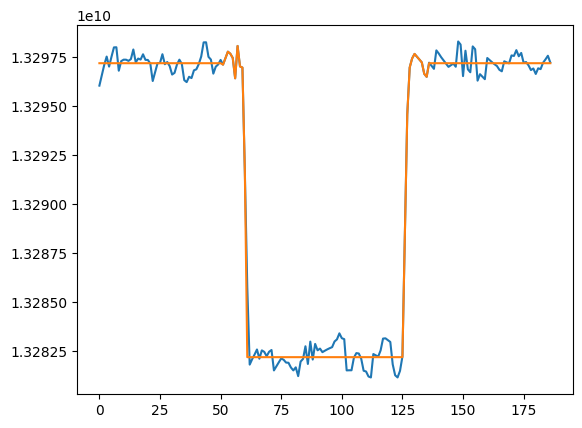

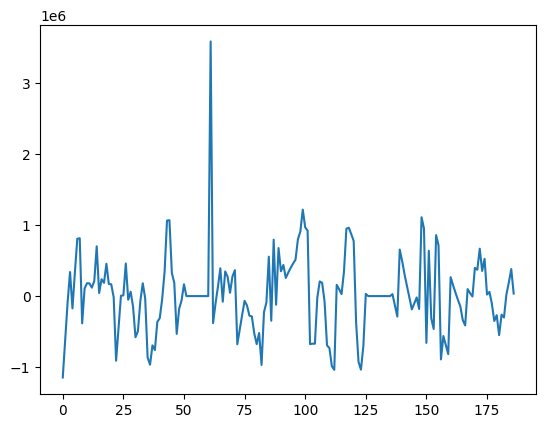

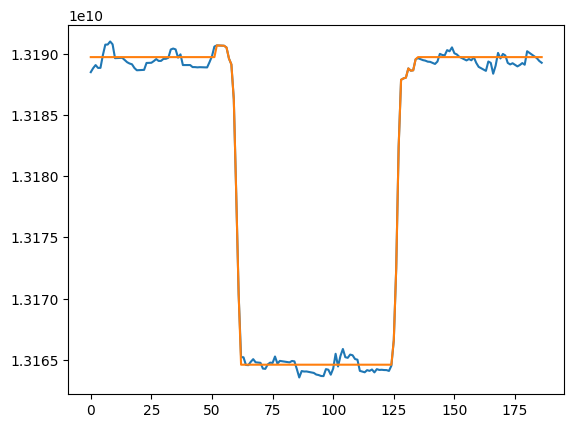

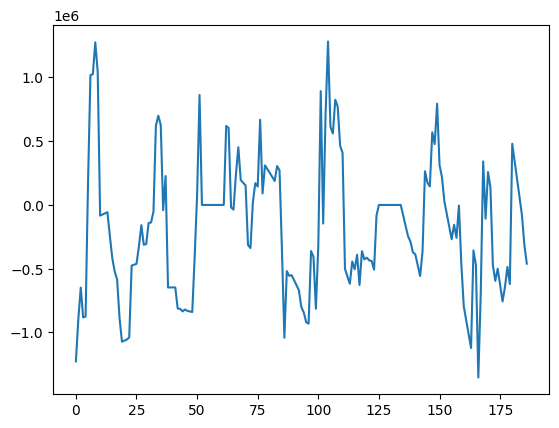

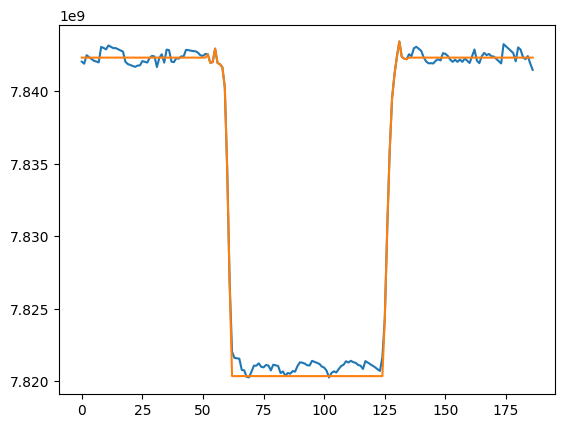

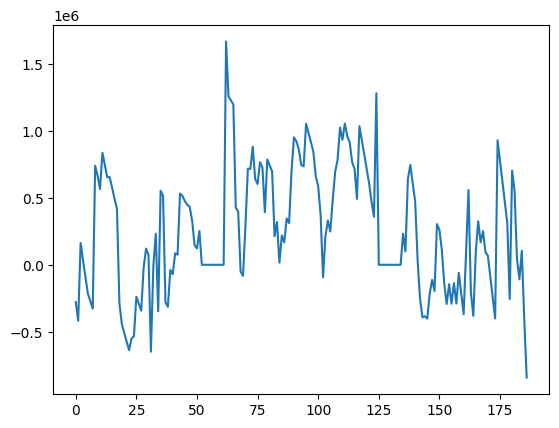

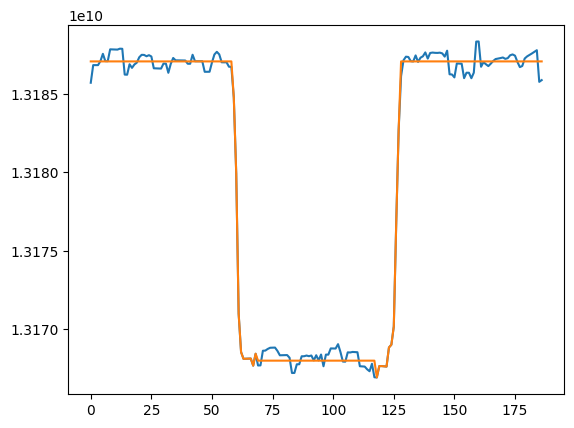

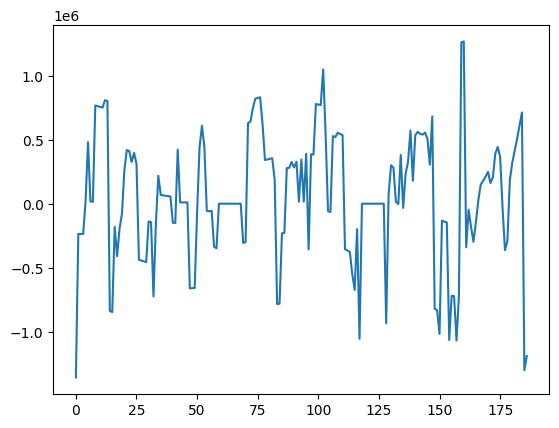

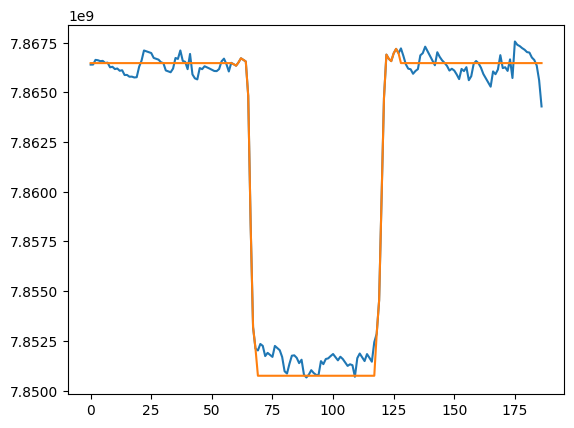

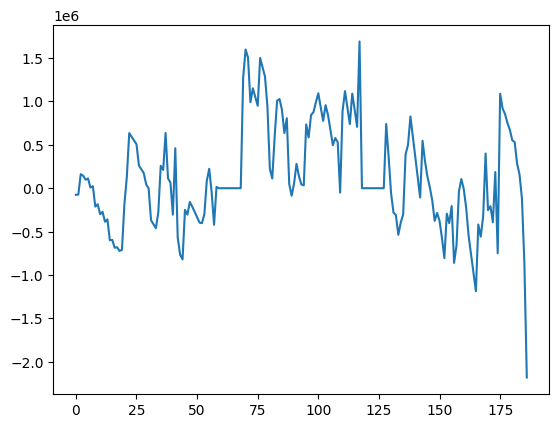

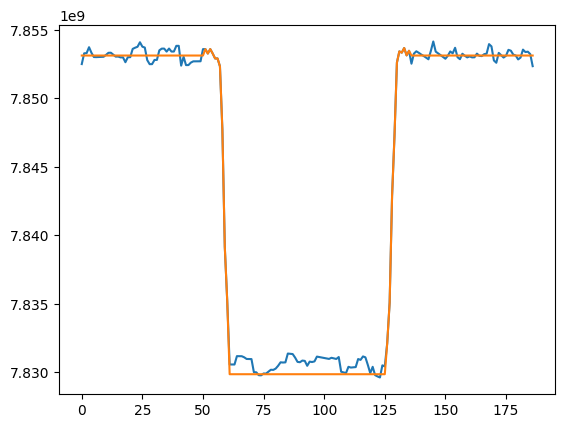

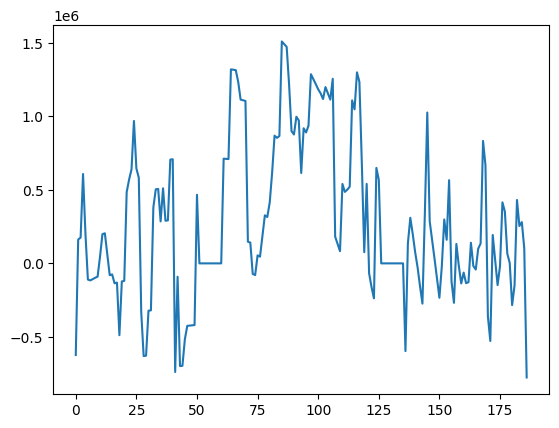

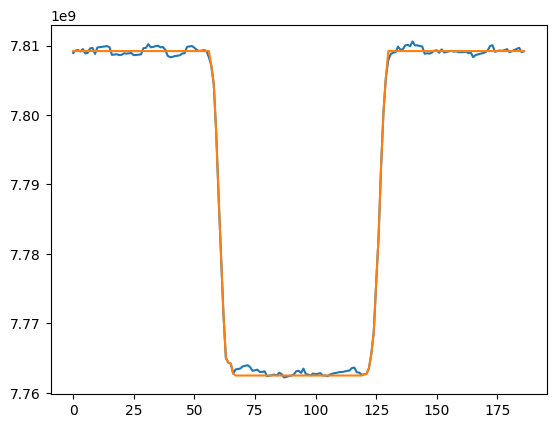

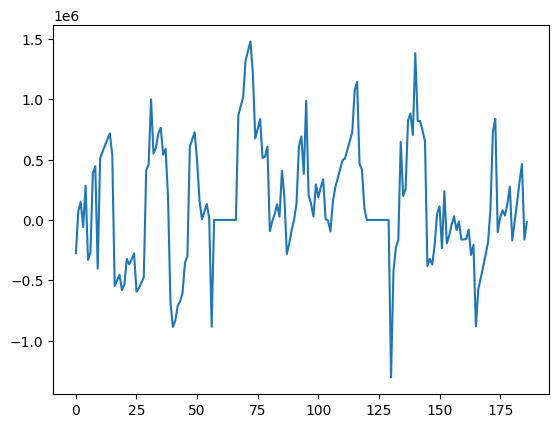

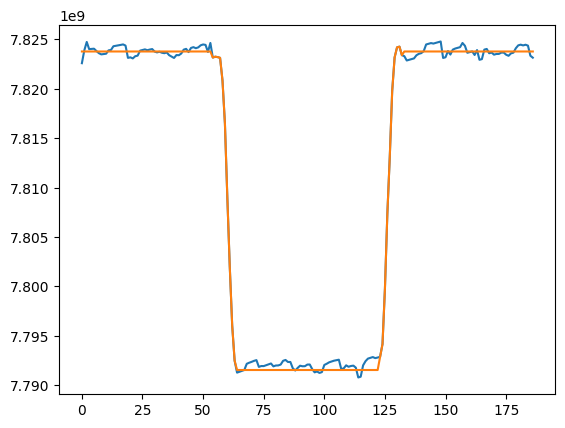

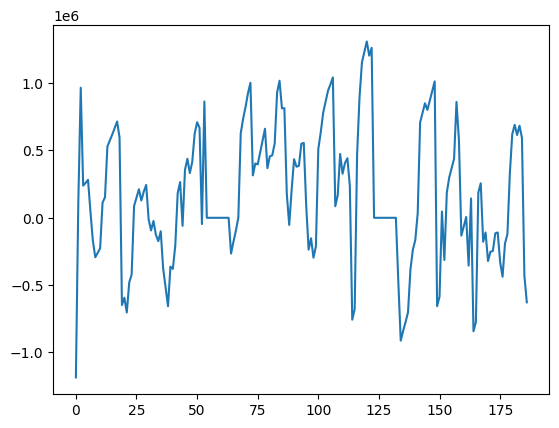

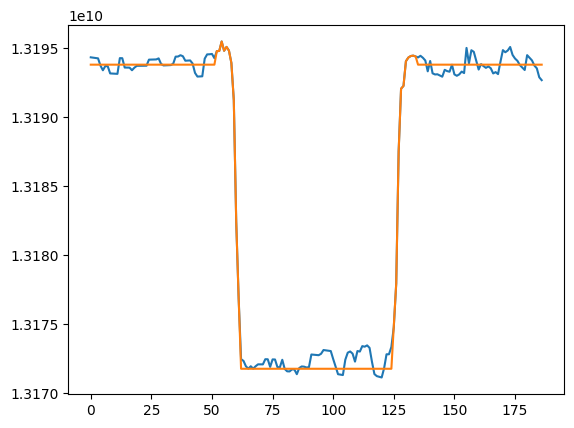

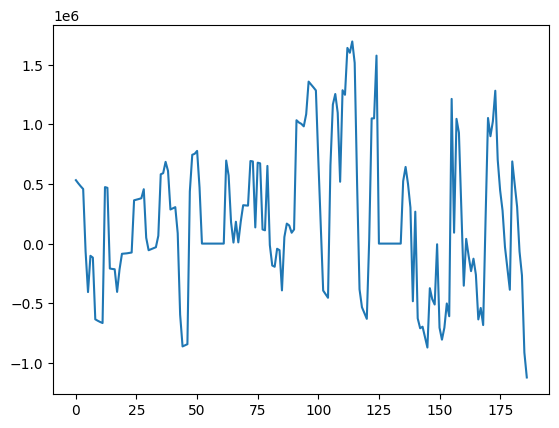

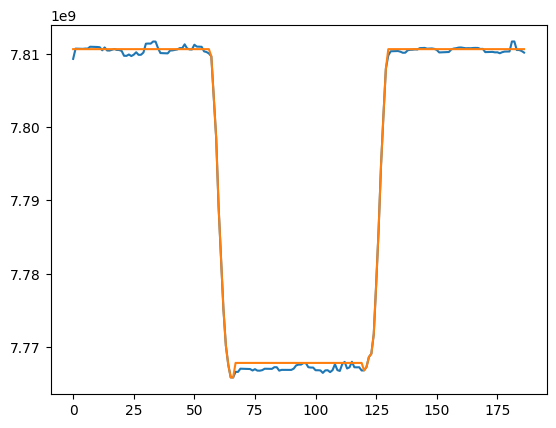

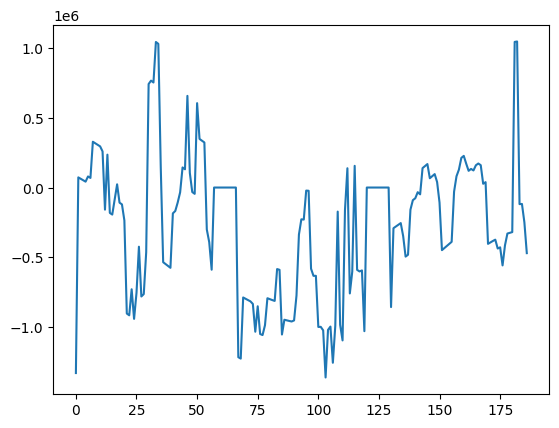

In [164]:
for i in range(10):
    observation = i
    ideal_wc = generate_ideal_wc(
        gt_selected[observation : observation + 1],
        wc_phases[observation : observation + 1],
        fitted_wc[observation : observation + 1],
        airs_selected[observation : observation + 1],
    )[0]
    plt.plot(fitted_wc[observation])
    plt.plot(ideal_wc)
    plt.show()

    plt.plot(fitted_wc[observation] - ideal_wc)
    plt.show()

Below section is for prediction generation.. boring...

In [249]:
sigmas.mean() * 1.7 - 5e-4

np.float64(-0.00011800766716606404)

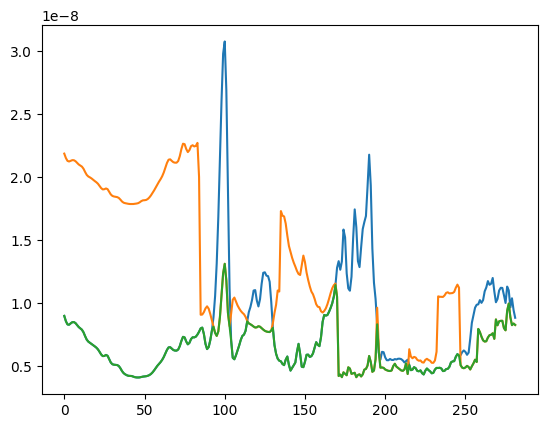

In [239]:
wc_error_array = ((wc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0)
lc_error_array = ((lc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0)
mask = wc_error_array > lc_error_array

combined_array = wc_error_array.copy()
combined_array[mask] = lc_error_array[mask]

combined_ratio = wc_ratio.copy()
combined_ratio[:, mask] = lc_ratio[:, mask]

plt.plot(((wc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0))
plt.plot(((lc_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0))
plt.plot(((combined_ratio - gt_selected[:, :-2]) ** 2).mean(axis=0))
# plt.plot(combined_array)

In [283]:
sample_sub = pd.read_csv("../data/raw/sample_submission.csv")
kaggle_sub = pd.read_csv("../data/sample_submissions/submission291024.csv")

In [320]:
kaggle_sub.iloc[:50, 2:].shape

(50, 565)

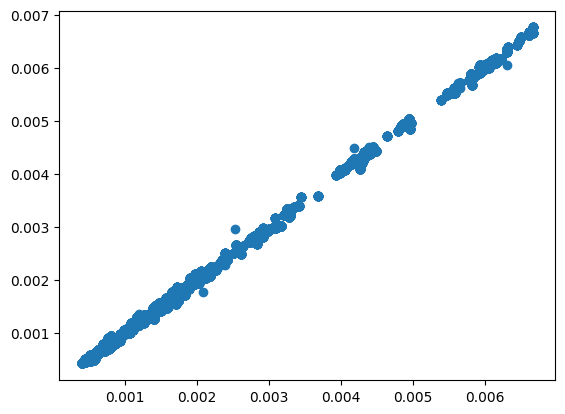

In [334]:
plt.scatter(kaggle_sub.iloc[:50, 2:284], lc_ratio[:, ::-1])

In [327]:
kaggle_sub

array([[ 152945.33205036,  167518.03056919,  179293.15174189, ...,
        3716503.96607244, 3330819.09042165, 2977718.46454588],
       [ 152970.63350563,  168562.38756292,  182148.83180432, ...,
        3716451.8636153 , 3327365.10121276, 2977529.11834869],
       [ 154119.70709701,  168375.76513209,  182572.53754668, ...,
        3712420.09736815, 3328114.29942712, 2980090.01118286],
       ...,
       [ 151961.53552395,  168526.32903853,  180878.48578944, ...,
        3715013.98646663, 3329931.49536155, 2979892.39101219],
       [ 150437.83545087,  168075.48774505,  181895.19386324, ...,
        3715109.52202257, 3327644.27330956, 2985244.67842812],
       [ 152514.17197247,  167851.10424386,  181469.8351688 , ...,
        3717957.02828245, 3324354.24841562, 2978358.57433418]])

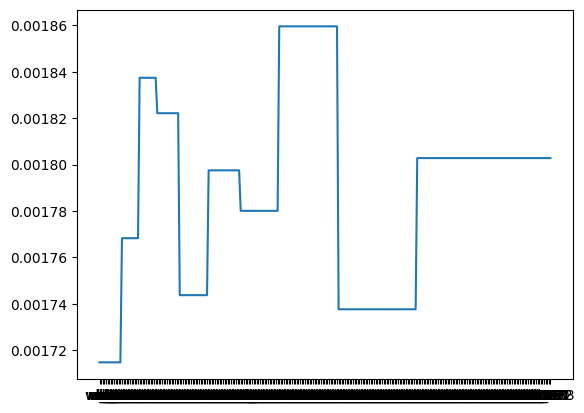

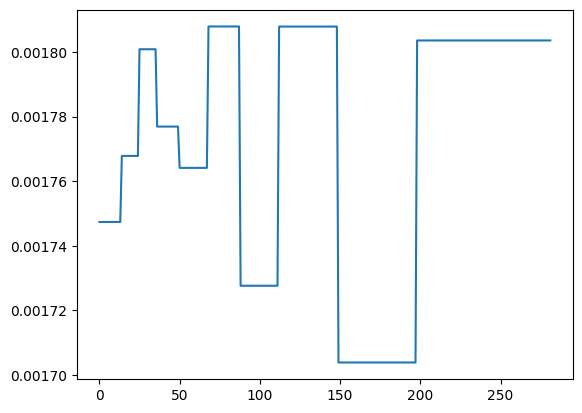

In [332]:
plt.plot(kaggle_sub.iloc[47][2:284])
plt.show()
plt.plot(lc_ratio[47][::-1])

In [331]:
np.argsort(
    (np.abs(kaggle_sub.iloc[:50, 2:284] - lc_ratio)).sum(axis=1), order="descending"
)

0     47
1     16
2     27
3     13
4     18
5     46
6     42
7      0
8     14
9     38
10    28
11     7
12    41
13    45
14    11
15     3
16    34
17    30
18    22
19     2
20     9
21    19
22    26
23    37
24    24
25     1
26    23
27    31
28    48
29    39
30    35
31    49
32    44
33    43
34     8
35    25
36    32
37    33
38    21
39     4
40     5
41    36
42    10
43    40
44    29
45    20
46    12
47     6
48    15
49    17
dtype: int64

In [43]:
axis_df = pd.read_parquet("../data/raw/axis_info.parquet")

In [ ]:
gt_df = pd.read_csv("../data/raw/train_labels.csv")

In [341]:
gt_df.iloc[:50, 2:].values.shape
kaggle_sub.iloc[:50, 2:284].shape

(50, 282)

In [360]:
# Find the best scaling value for sigma
best_score = 0
best_scale = 0
naive_mean = np.mean(gt_df.values[:, 1:])
naive_sigma = np.std(gt_df.values[:, 1:])

for i in np.arange(1, 3, 0.01):
    # preds = wc_ratio.copy()
    # preds = combined_ratio[:, ::-1].copy()
    preds = kaggle_sub.iloc[:50, 2:284].copy()
    # preds[:,mask] = lc_ratio[:,mask]
    # preds = lc_ratio[:, ::-1].copy()
    # print('a', preds[0, -51:])
    # preds[:,-80:] = wc_ratio[:,-80:]
    # print(preds[0, -51:])

    # print(preds.shape)
    constant_value = np.full((preds.shape[0], 1), lc_ratio.mean())
    # print(preds.mean())
    constant_value = np.full((preds.shape[0], 1), preds.mean().mean())
    # print(preds.shape)

    sigmas = np.vstack(
        [np.std((lc_ratio[:, ::-1] - gt_df.iloc[:50, 2:].values), axis=0) * i]
        * lc_ratio.shape[0]
    )

    sigmas = np.vstack(
        [np.std((preds - gt_df.iloc[:50, 2:].values), axis=0) * i] * lc_ratio.shape[0]
    )

    # sigmas = np.vstack(
    #     [np.std((combined_ratio[:, ::-1] - gt_df.iloc[:50, 2:].values), axis=0) * i]
    #     * lc_ratio.shape[0]
    # )

    preds = np.hstack((constant_value, preds))
    constant_value = np.full((sigmas.shape[0], 1), sigmas.mean())
    sigmas = np.hstack((constant_value, sigmas))
    # print(preds.shape)
    # print(sigmas.shape)

    sub_frame = pd.DataFrame(
        np.concatenate([preds, sigmas], axis=1), columns=sample_sub.columns[1:]
    )

    curren_score = score(
        gt_df.iloc[:50, 1:], sub_frame, "", naive_mean, naive_sigma, 10**-5
    )
    if curren_score > best_score:
        best_score = curren_score
        best_scale = i

print(f"Best scale at {best_scale}, best score at {best_score}")

Best scale at 1.3800000000000003, best score at 0.43793602055886


--------------- End of prediction calibration ----------------->

In [181]:
Best scale at 1.01, best score at 0.39852919678755844


SyntaxError: invalid syntax (4057612712.py, line 1)

In [80]:
score(
    gt_df.iloc[:, 1:], sub_frame, "", naive_mean, naive_sigma, 10**-5, by_freq=True
).mean().mean()

np.float64(0.41763268988718)

In [92]:
score(gt_df.iloc[:, 1:], sub_frame, "", naive_mean, naive_sigma, 10**-5)

1365086.9667932629


0.3936332958615849

In [91]:
scipy.stats.norm.logpdf(
    gt_df.iloc[:, 1:], loc=sub_frame.iloc[:, :283], scale=sigmas
).sum()

np.float64(1365086.9667932629)

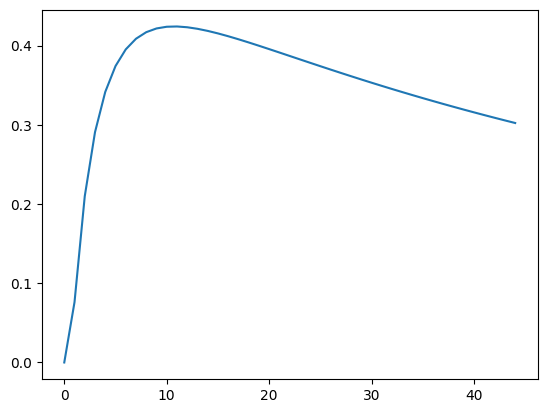

In [ ]:
score_list = []
for i in np.arange(0.00005, 0.0005, 0.00001):
    score_list.append(simple_score(lc_ratio, i, gt_selected[:, :-2]))
plt.plot(score_list)

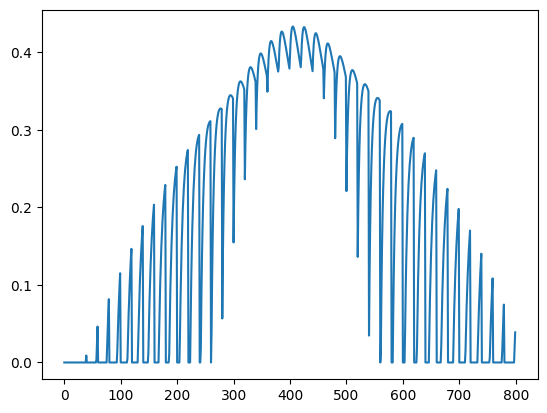

In [1014]:
score_list = []
for j in np.arange(0.8, 1.2, 0.01):
    for i in np.arange(0.0001, 0.0003, 0.00001):
        score_list.append(simple_score(wc_ratio * j, i, gt_selected[:, :-2]))
plt.plot(score_list)

In [734]:
# Diagnostics and observations
# Using optimized breakpoint gives better results. use a window size of 7 for buffe

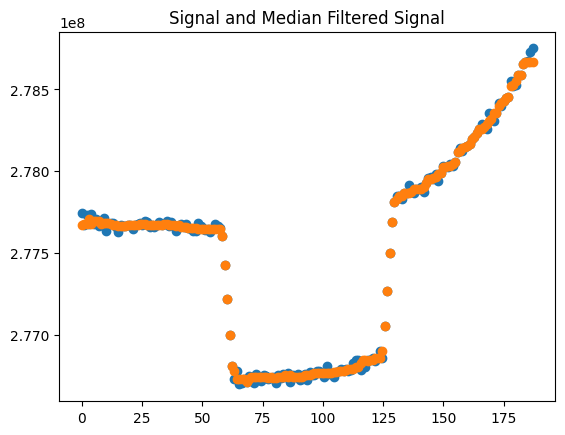

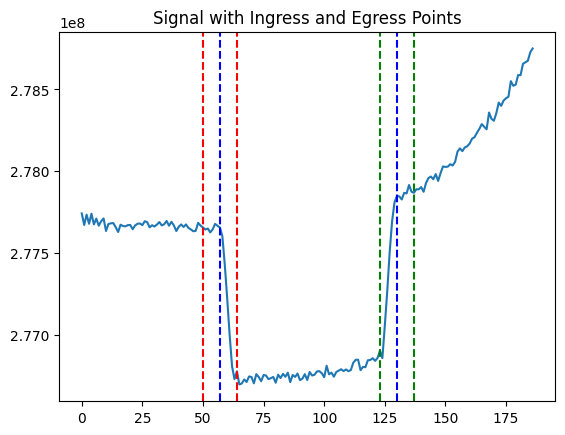

In [585]:
observation = 55
signal = airs_selected[observation].sum(axis=1)
# signal = airs_selected[observation][:,2]
signal_med_fit = medfilt(signal, 7)

plt.scatter(np.linspace(0, 187, 187), signal)
plt.scatter(np.linspace(0, 187, 187), signal_med_fit)
plt.title("Signal and Median Filtered Signal")
plt.show()

plt.plot(signal)
ingress, egress = optimize_breakpoint(signal_med_fit, 50)
# egress = len(signal) - ingress

# ingress, egress = phase_detector(airs_selected[0].sum(axis=1))

plt.axvline(x=ingress, color="b", linestyle="--")
plt.axvline(x=egress, color="b", linestyle="--")

plt.axvline(x=ingress - 7, color="r", linestyle="--")
plt.axvline(x=ingress + 7, color="r", linestyle="--")

plt.axvline(x=egress + 7, color="g", linestyle="--")
plt.axvline(x=egress - 7, color="g", linestyle="--")

plt.title("Signal with Ingress and Egress Points")
plt.show()

0.0020040283203125037


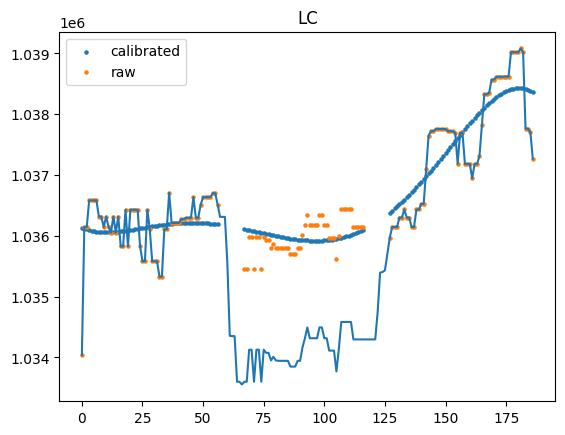

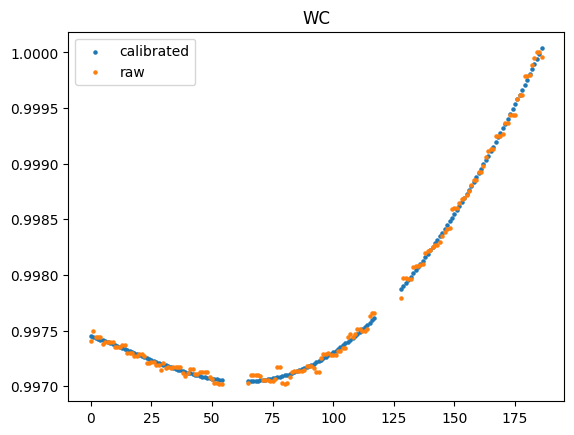

In [581]:
observation = 250
signal_wc = airs_selected[observation].sum(axis=1)
signal_lc = airs_selected[observation][:, 120]  # .sum(axis=1)

# signal_wc = raw_wc


signal_lc_med_fit = medfilt(signal_lc, 11)

# signal_lc_med_fit /= signal_lc_med_fit.max()
calibrated_lc_signal = calibrate_signal(signal_lc_med_fit)

signal_wc_med_fit = medfilt(signal_wc, 3)
calibrated_wc_signal = calibrate_signal(signal_wc_med_fit)
print(calibrated_wc_signal[0])

plt.plot(signal_lc_med_fit)
plt.scatter(calibrated_lc_signal[1], calibrated_lc_signal[3], s=5, label="calibrated")
plt.scatter(calibrated_lc_signal[1], calibrated_lc_signal[2], s=5, label="raw")
plt.title("LC")
plt.legend()
plt.show()

# plt.plot(signal_wc_med_fit)
plt.scatter(
    calibrated_wc_signal[1],
    calibrated_wc_signal[3] / signal_wc_med_fit.max(),
    s=5,
    label="calibrated",
)
plt.scatter(
    calibrated_wc_signal[1],
    calibrated_wc_signal[2] / signal_wc_med_fit.max(),
    s=5,
    label="raw",
)
plt.title("WC")
plt.legend()
plt.show()

In [ ]:
airs, fgs, gt = read_files(selected_targets[observation], gt_df)
raw_wc = airs[0].sum(axis=(1, 2))
plt.plot(raw_wc / raw_wc.max(), label="raw")

processed_airs = subtract_background(airs, edge_pixel=1)
print(processed_airs.shape)

plt.plot(
    processed_airs[0].sum(axis=(1, 2)) / processed_airs[0].sum(axis=(1, 2)).max(),
    label="subtracted",
)


processed_airs = spatial_integration(processed_airs)
plt.plot(
    processed_airs[0].sum(axis=(1)) / processed_airs[0].sum(axis=(1)).max(),
    label="spatial integrated",
)


plt.plot(
    airs_selected[observation].sum(axis=1)
    / airs_selected[observation].sum(axis=1).max(),
    label="processed",
)
plt.legend()
plt.show()

# plt.plot(processed_airs[0].sum(axis=(1)))
# plt.plot(wavelet_smoothing(processed_airs, 5)[0].sum(axis=(1)), label="wavelet")
plt.plot(airs_selected[1].sum(axis=1), label="processed")
plt.plot(raw_wc, label="raw")
plt.legend()

plt.show()

plt.plot(processed_airs[0].sum(axis=(1)) - calibrated_wc_signal[4](np.arange(187)) * 0)
plt.plot(calibrated_wc_signal[4](np.arange(187)))
plt.show()

plt.plot(
    -1
    * (processed_airs[0].sum(axis=(1)) - calibrated_wc_signal[4](np.arange(187)))
    / processed_airs[0].sum(axis=(1))
)
plt.axhline(y=gt_selected[observation][:-2].mean(), color="r", linestyle="--")
plt.show()

plt.plot(gt_selected[observation][:-1])
plt.axhline(
    y=calibrated_wc_signal[0], color="r", linestyle="--", label="Model Prediction"
)
new_model = np.median(
    (
        -1
        * (processed_airs[0].sum(axis=(1)) - calibrated_wc_signal[4](np.arange(187)))
        / processed_airs[0].sum(axis=(1))
    )[wc_phases[observation][0] : wc_phases[observation][1]]
)
plt.axhline(y=new_model, color="g", linestyle="--", label="New Model")
plt.title("GT")
plt.legend()
plt.show()

In [ ]:
calibrated_lc_signal = calibrate_signal_with_prior(
    signal_lc_med_fit, calibrated_wc_signal[4]
)

plt.plot(signal_lc_med_fit)

plt.scatter(calibrated_lc_signal[1], calibrated_lc_signal[3], s=5, label="calibrated")
plt.scatter(calibrated_lc_signal[1], calibrated_lc_signal[2], s=5, label="raw")
plt.title("LC")
plt.legend()
plt.show()

In [842]:
airs_selected[0].shape

(187, 282)

In [893]:
full_binned_series = bin_frequencies(airs_selected, 10)

(1, 187, 10) [[[ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]
  [ 62 125]]]


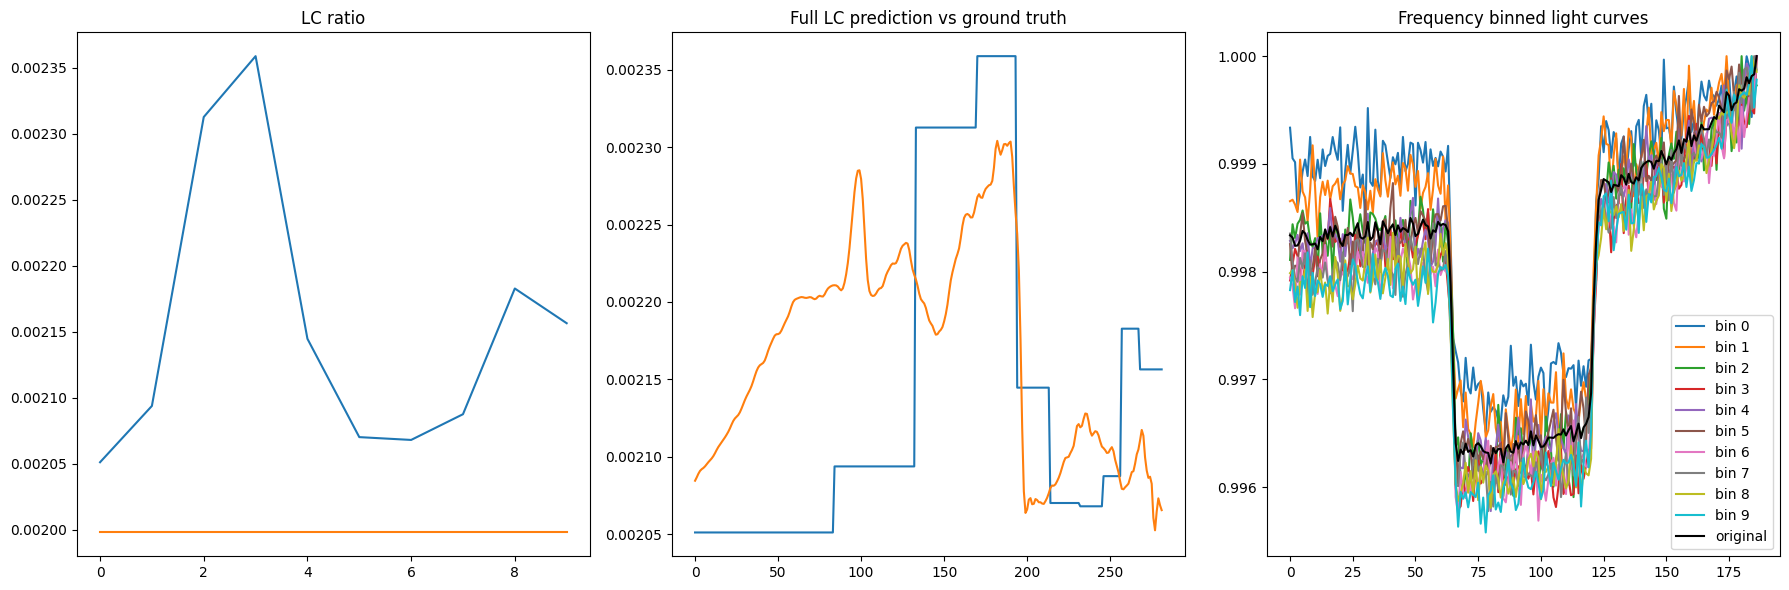

In [825]:
# Try binning the raw ligth curves by frequency, so we obtain bins of roughly equal strength
# it seems that we are quite off in the dip calculation
bins = 10
series_index = 5
binned_series, bin_indices = bin_frequencies(airs_selected[series_index], bins)

# mirror phases detected in the white curve
wc_phase_approx = np.repeat(
    wc_phases[series_index : series_index + 1, np.newaxis, :], bins, axis=1
)

# reshape ground truth to show the mean value
gt_array = []
bin_indices.insert(0, 0)
bin_indices.append(282)
for i in range(len(bin_indices) - 1):
    gt_array.append(
        gt_selected[series_index, bin_indices[i] : bin_indices[i + 1]].mean()
    )

# reshape time series for model fitting
binned_series = binned_series.reshape(1, 187, bins)
print(binned_series.shape, wc_phase_approx)

fitted_lc, fitted_wc = model_runner(
    binned_series, wc_phase_approx, wc_phases, calibrate_signal
)

# Cal prediction
lc_ratio, wc_ratio = calculate_spectrum(
    fitted_lc, fitted_wc, wc_phase_approx, wc_phases
)

# ans_lc, _ = calculate_spectrum(fitted_lc, fitted_wc, lc_phases, wc_phases)

full_lc_pred = np.zeros(282)
for i in range(len(bin_indices) - 1):
    full_lc_pred[bin_indices[i] : bin_indices[i + 1]] = lc_ratio[0, i]
    # print(ans_lc[0, i])

np.mean((full_lc_pred - gt_selected[0][:-2]) ** 2)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot LC ratio
axs[0].plot(lc_ratio[0])
axs[0].plot(wc_ratio[0])
axs[0].set_title("LC ratio")

# Plot Full LC prediction vs ground truth
axs[1].plot(full_lc_pred)
axs[1].plot(gt_selected[series_index][:-2])
axs[1].set_title("Full LC prediction vs ground truth")

# Plot Frequency binned light curves
for i in range(bins):
    axs[2].plot(binned_series[0][:, i] / binned_series[0][:, i].max(), label=f"bin {i}")
axs[2].plot(
    airs_selected[series_index].sum(axis=1)
    / airs_selected[series_index].sum(axis=1).max(),
    color="black",
    label="original",
)
axs[2].set_title("Frequency binned light curves")
axs[2].legend()

plt.tight_layout()
plt.show()

In [836]:
simple_score(full_lc_pred, 0.00009, gt_selected[series_index][:-2])

0.45477456103392394

In [11]:
# check for gpu
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

normalized_fitted_wc = fitted_wc / fitted_wc.max(axis=1, keepdims=True)

ideal_lc = generate_ideal_lc(gt_selected, wc_phases, fitted_wc, airs_selected)
normalized_ideal_lc = ideal_lc / ideal_lc.max(axis=1, keepdims=True)

gt_absorption = gt_selected[:, :-1].mean(axis=1)

time_series = (
    torch.tensor(normalized_fitted_wc, dtype=torch.float32).unsqueeze(-1).to(mps_device)
)
target_series = (
    torch.tensor(normalized_ideal_lc, dtype=torch.float32).unsqueeze(-1).to(mps_device)
)
target_absorption = (
    torch.tensor(gt_absorption, dtype=torch.float32).unsqueeze(-1).to(mps_device)
)

tensor([1.], device='mps:0')


In [25]:
# check for gpu
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [120]:
def predictor_benchmark(star_id_list, predictor, gt_df, error):
    predictor_output = []
    gt_output = []
    scores = []
    naive_mean = np.mean(gt_df.values[:, 1:])
    naive_sigma = np.std(gt_df.values[:, 1:])
    for i in star_id_list:
        airs_df, fgs_df, gt = read_files(i, gt_df)
        predictions = predictor(airs_df)
        planet_gt = pd.DataFrame(gt_df[gt_df.planet_id == i].values[0][:1:-1]).T

        predictor_output.append(predictions)
        gt_output.append(planet_gt.values)
        planet_sub = pd.DataFrame(np.hstack((predictions, np.array([error] * 282)))).T

        scores.append(
            metrics.score(planet_gt, planet_sub, "", naive_mean, naive_sigma, 10**-5)
        )

    return predictor_output, gt_output, scores

In [122]:
scores = []

snaive_mean = np.mean(gt_df.values[:, 1:])
naive_sigma = np.std(gt_df.values[:, 1:])

# for k in [0.0004, 0.00045, 0.0005]:
# for k in [0.00019, 0.000195, 0.00028]:


for i in range(100):
    target_star = target_star_list[i]
    airs_df, fgs_df, gt = read_files(target_star, gt_df)

    # raw_prediction, fitted_wc = calc_ratio(airs_df[0], False)
    # results = calibrate_train(airs_df[0].sum(axis=2))
    # raw_prediction = [result[0] for result in results]
    raw_prediction = np.repeat(calibrate_signal(airs_df[0].sum(axis=(1, 2)))[0], 282)
    predictions = np.clip(raw_prediction, a_min=0, a_max=None)

    planet_sub = pd.DataFrame(np.hstack((predictions, np.array([0.00016] * 282)))).T

    planet_gt = pd.DataFrame(gt_df[gt_df.planet_id == target_star].values[0][:1:-1]).T
    scores.append(
        metrics.score(planet_gt, planet_sub, "", naive_mean, naive_sigma, 10**-5)
    )

print(np.mean(scores))

0.42913239735795083


In [344]:
# empirically find that the best sigma is at around 2.1399
for i in np.arange(2, 3, 0.01):
    modified_sigmas = sample_sub.iloc[:, 284:] * i
    combined_df = pd.concat([sample_sub.iloc[:, :284], modified_sigmas], axis=1)
    print(
        f'score at {i} : {score(gt_df.iloc[:,1:], combined_df.iloc[:,1:], "", naive_mean, naive_sigma, 10**-5)}'
    )

score at 2.0 : 0.3786080704022527
score at 2.01 : 0.3787305358525717
score at 2.0199999999999996 : 0.3788424919276484
score at 2.0299999999999994 : 0.37894418803151214
score at 2.039999999999999 : 0.3790358670504204
score at 2.049999999999999 : 0.3791177655493042
score at 2.0599999999999987 : 0.37919011396143176
score at 2.0699999999999985 : 0.37925313677155803
score at 2.0799999999999983 : 0.3793070526928163
score at 2.089999999999998 : 0.3793520748375839
score at 2.099999999999998 : 0.3793884108825672
score at 2.1099999999999977 : 0.3794162632283137
score at 2.1199999999999974 : 0.37943582915337354
score at 2.1299999999999972 : 0.37944730096330587
score at 2.139999999999997 : 0.37945086613473133
score at 2.149999999999997 : 0.3794467074546089
score at 2.1599999999999966 : 0.3794350031549252
score at 2.1699999999999964 : 0.37941592704295884
score at 2.179999999999996 : 0.3793896486272867
score at 2.189999999999996 : 0.37935633323969253
score at 2.1999999999999957 : 0.37931614215312054

In [ ]:
preds = lc_ratio[:, ::-1]
# preds = wc_ratio
constant_value = np.full((preds.shape[0], 1), lc_ratio.mean())
preds = np.hstack((constant_value, preds))

sigmas = np.vstack(
    [np.std((lc_ratio[:, ::-1] - gt_df.iloc[:, 1:].values), axis=0) * i]
    * lc_ratio.shape[0]
)
constant_value = np.full((sigmas.shape[0], 1), sigmas.mean())
sigmas = np.hstack((constant_value, sigmas))

sub_frame = pd.DataFrame(
    np.concatenate([preds, sigmas], axis=1), columns=sample_sub.columns[1:]
)
# sub_frame.index = gt_df.planet_id

naive_mean = np.mean(gt_df.values[:, 1:])
naive_sigma = np.std(gt_df.values[:, 1:])
print(i, score(gt_df, sub_frame, "", naive_mean, naive_sigma, 10**-5))